<a href="https://colab.research.google.com/github/emiresenov/SESBC-Webinar/blob/main/SESBC_Webinar_Emir_Esenov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neural Networks 101: Supervised Learning for Regression (Hands‑On)

**Goal:** Learn what *supervised learning* is and train a small neural network to fit noisy data.
We'll visualize the model's predictions and track the Mean Squared Error (MSE) during training.

**What you'll do:**
- Generate a simple synthetic dataset for a regression task.
- Build a small neural network (multilayer perceptron).
- Train it with gradient descent.
- Plot the model's predictions and MSE across iterations.



## What is supervised learning?

In **supervised learning**, we train a model using input–output pairs: $(\mathbf{x}_i, y_i)$.
The model learns a function $ f_\theta(\mathbf{x}) $(with parameters $\theta$ representing the neural network's weights and biases) that maps inputs to outputs.
Training adjusts $\theta$ to make predictions $\hat{y}_i = f_\theta(\mathbf{x}_i)$ close to the true labels $y_i$.

We measure "closeness" with a **loss function**. For regression, a common choice is **Mean Squared Error (MSE)**:

$$
\text{MSE}(\theta) \;=\; \frac{1}{N} \sum_{i=1}^{N} \big(f_\theta(\mathbf{x}_i) - y_i\big)^2.
$$

**Training loop (high level):**
1. Start with random parameters $\theta$.
2. Compute the loss on the training data.
3. Compute gradients of the loss w.r.t. $\theta$.
4. Update $\theta$ to reduce the loss (e.g., with gradient descent).
5. Repeat for many iterations (epochs) until the model fits well.


In [1]:

#@title Setup: import software libraries
import math
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Set a seed for the random number generator for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# define device for pytorch (gpu acceleration if available, otherwise cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

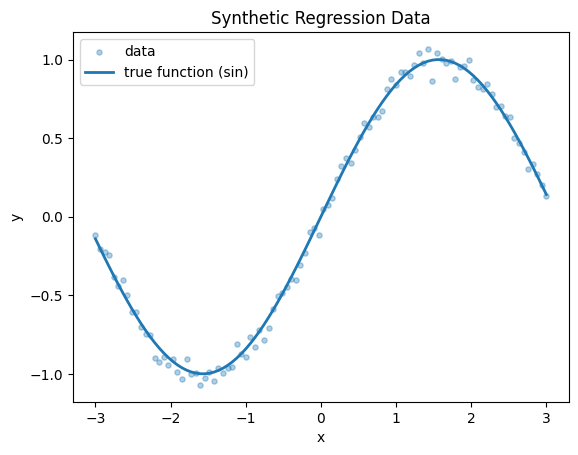

In [2]:

#@title Create and visualize a synthetic dataset (noisy sine curve)
N = 100  # number of data points

# create evenly spaced points on x-axis
X = np.linspace(-3.0, 3.0, N).reshape(-1, 1).astype(np.float32)

noise = 0.05 * np.random.randn(N, 1).astype(np.float32)
y_true_func = np.sin(X)  # the true function that we wish to learn
y = y_true_func + noise  # generate noisy observations

X_t = torch.from_numpy(X).to(device) # load data to PyTorch
y_t = torch.from_numpy(y).to(device) # load data to PyTorch

# Wrap in a PyTorch DataLoader
batch_size = 32
train_ds = TensorDataset(X_t, y_t)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Quick preview plot of the data
plt.figure()
plt.scatter(X, y, s=14, alpha=0.35, label="data")
plt.plot(X, y_true_func, linewidth=2, label="true function (sin)")
plt.legend()
plt.title("Synthetic Regression Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [3]:

#@title Define a small neural network (MLP) for regression
class MLP(nn.Module):
    # define input dimension (1), amount of neurons in hidden layer (64), and output dimension (1)
    def __init__(self, in_features=1, hidden=64, out_features=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden),  # apply affine linear transformation to the incoming data: y = x*W^T + b.
            nn.ReLU(),                       # apply nonlinear activation function, in this case RelU
            nn.Linear(hidden, hidden),       # ...repeat process for a second layer
            nn.ReLU(),
            nn.Linear(hidden, out_features), # final linear transformation to produce the output
        )
    def forward(self, x):
        return self.net(x)

model = MLP().to(device)
model


MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

Epoch    1/800 - MSE: 0.4017
Epoch  100/800 - MSE: 0.0033
Epoch  200/800 - MSE: 0.0028
Epoch  300/800 - MSE: 0.0036
Epoch  400/800 - MSE: 0.0042
Epoch  500/800 - MSE: 0.0059
Epoch  600/800 - MSE: 0.0032
Epoch  700/800 - MSE: 0.0048
Epoch  800/800 - MSE: 0.0031


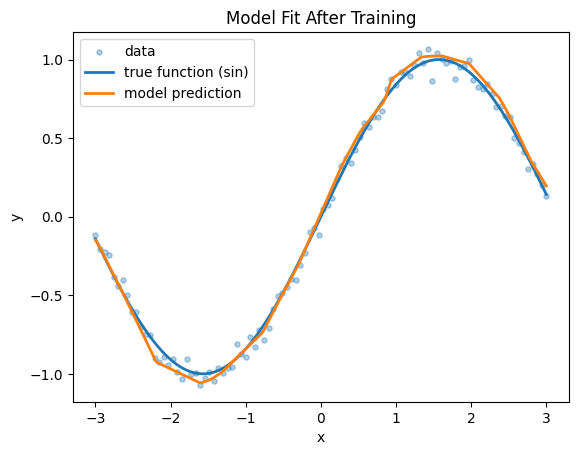

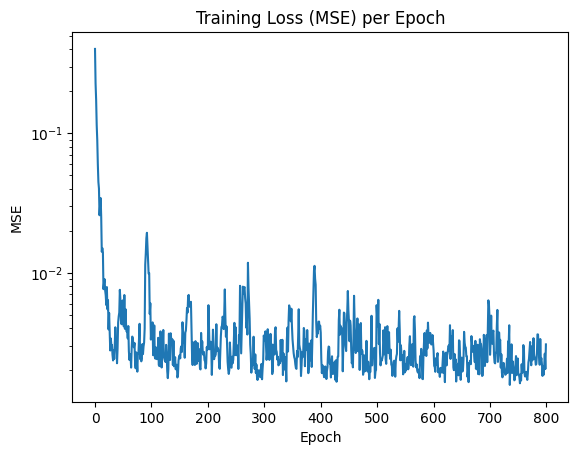

In [4]:

#@title Train the model and record MSE each iteration
epochs = 800             # number of passes through the data
lr = 1e-2                # learning rate
criterion = nn.MSELoss() # define loss function

# Initialize the Adam optimizer (common choice for optimizing neural networks)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_history = []

# For visualization of the fit, create a dense grid
X_grid = np.linspace(-3.0, 3.0, 300).reshape(-1, 1).astype(np.float32)
Xg_t = torch.from_numpy(X_grid).to(device)

# Training loop — iterates through the data multiple times (epochs) to train the model
for epoch in range(1, epochs + 1):

    # Set the model to training mode (enables dropout, batchnorm updates, etc.)
    model.train()

    # Initialize a running total for the loss over the epoch
    running_loss = 0.0

    # Iterate over batches of training data from the DataLoader
    for xb, yb in train_loader:
        optimizer.zero_grad()                     # Reset gradients from the previous batch (otherwise they accumulate)
        preds = model(xb)                         # Forward pass: compute model predictions for the current batch
        loss = criterion(preds, yb)               # Compute the loss between predictions and true labels
        loss.backward()                           # Backward pass: compute gradients of loss w.r.t. model parameters
        optimizer.step()                          # Update model parameters using the optimizer
        running_loss += loss.item() * xb.size(0)  # Accumulate the batch loss, weighted by batch size

    # Compute the average loss over the entire dataset for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)

    # Store the epoch loss in history for later analysis/plotting
    loss_history.append(epoch_loss)

    # Print the loss every 100 epochs or on the first epoch for monitoring progress
    if epoch % 100 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d}/{epochs} - MSE: {epoch_loss:.4f}")

# Final predictions on the dense grid
model.eval()
with torch.no_grad():
    y_hat_grid = model(Xg_t).cpu().numpy()

# Plot the learned function vs data
plt.figure()
plt.scatter(X, y, s=14, alpha=0.35, label="data")
plt.plot(X_grid, np.sin(X_grid), linewidth=2, label="true function (sin)")
plt.plot(X_grid, y_hat_grid, linewidth=2, label="model prediction")
plt.legend()
plt.title("Model Fit After Training")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot the MSE across epochs
plt.figure()
plt.plot(loss_history)
plt.title("Training Loss (MSE) per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.yscale('log')
plt.show()


## Exercises
- Play around with the size of the neural network (amound of layers and number of neurons in the hidden layers) and rerun the code blocks. How does it affect the results of the neural network?
- Play around with the length of training (number of epochs) and the learning rate and rerun the code blocks. How does that impact the training process?

## Takeaways
- Supervised learning uses labeled examples to teach a model to map inputs to outputs.
- We train the neural network by adjusting it's parameters (weights and biases) through iterative steps minimizing the loss function.
- A small neural network (with just a few layers) can approximate smooth nonlinear functions.
- Tracking MSE over time shows whether the model is improving; a downward trend indicates learning.
- Next: we can extend this notebook to Physics-Informed Neural Networks (PINNs) by **adding physical constraints** to the loss.

---


# Neural Networks vs PINNs on 1D Poisson — A Hands‑On Comparison

This notebook walks through a physics‑related example that highlights *how a PINN differs from (and improves on) a plain neural network (NN).*  
We will:
1. **Solve a 1D Poisson problem** with a plain NN using only data (supervised learning).
2. **Augment the NN into a PINN** by adding physics residuals and boundary terms to the loss.
3. Show that **PINNs regularize** the NN and produce better solutions on **noisy data**.
4. Show that **PINNs may extrapolate** to **unobserved parts of the domain**.
5. **Inverse PINN:** learn an **unknown PDE parameter** jointly with the network weights.

We'll keep the code small and readable and explain each step as we go.



## The PDE (forward problem)

We consider the boundary value problem on $x \in [0,1]$:
$$
u''(x) = -\,a\,\pi^2 \sin(\pi x), \qquad u(0)=0,\; u(1)=0,
$$
whose exact solution is
$$
u(x) = a\,\sin(\pi x),
$$
where $a$ is a scalar parameter.  
For the **forward** problem we set $a=1$. Later, we will treat $a$ as **unknown** and learn it (inverse PINN).


In [5]:

#@title Setup (PyTorch + Matplotlib) and helpers
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

def exact_u(x, a=1.0):
    return np.sin(np.pi * x) * a

def to_torch(x, requires_grad=False):
    t = torch.as_tensor(x, dtype=torch.float32, device=device)
    t.requires_grad_(requires_grad)
    return t



## Data: noisy observations on a limited domain

To stress‑test extrapolation, we only observe data for $x \le 0.6$.  
We also add Gaussian noise so that pure data‑fitting might overfit:

- Observed inputs: $x_{\text{obs}} \sim \text{Uniform}(0, 0.6)$
- Observed outputs: $y_{\text{obs}} = u(x_{\text{obs}}) + \varepsilon,\; \varepsilon \sim \mathcal{N}(0,\sigma^2)$

We'll compare how a plain NN (supervised learning) and a PINN behave on this setup.


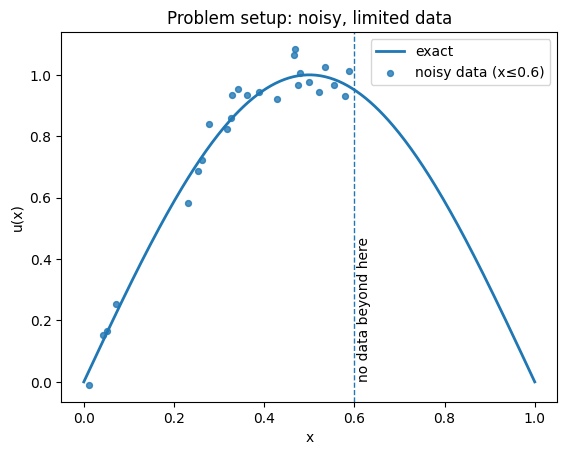

In [6]:

#@title Generate and plot data
a_true = 1.0        # true a parameter value
sigma = 0.05        # noise std
N_obs = 25          # number of observed points

# Observed data only on the left portion of the domain
x_obs = np.random.rand(N_obs) * 0.6     # in [0, 0.6]
x_obs = np.sort(x_obs)
y_obs_clean = exact_u(x_obs, a=a_true)
y_obs = y_obs_clean + sigma * np.random.randn(N_obs)

# Dense grid for evaluation on [0, 1]
x_grid = np.linspace(0.0, 1.0, 300)
y_true = exact_u(x_grid, a=a_true)

# Plot the data vs. exact solution
plt.figure()
plt.plot(x_grid, y_true, linewidth=2, label="exact")
plt.scatter(x_obs, y_obs, s=18, alpha=0.8, label="noisy data (x≤0.6)")
plt.axvline(0.6, linestyle="--", linewidth=1)
plt.text(0.605, 0.0, "no data beyond here", rotation=90, va="bottom")
plt.title("Problem setup: noisy, limited data")
plt.xlabel("x"); plt.ylabel("u(x)")
plt.legend()
plt.show()



## Part 1 — Plain NN (supervised learning only)

We fit a small MLP $f_\theta(x)$ to the observed pairs $(x_i, y_i)$ by minimizing **MSE**:
$$
\mathcal{L}_{\text{data}}(\theta) = \frac{1}{N}\sum_{i=1}^N \big(f_\theta(x_i) - y_i\big)^2.
$$

**Expectation:** A plain NN can match the noisy samples where we have data, but it has **no guidance** on the unseen part of the domain $[0.6,1]$, so extrapolation is arbitrary.


In [7]:

#@title Define and train a plain NN on (x_obs, y_obs)
class MLP(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden),       # linear transf. from input layer to first hidden layer
            nn.Tanh(),                  # tanh activation function
            nn.Linear(hidden, hidden),  # linear transf. first hidden layer to second hidden layer
            nn.Tanh(),                  # tanh activation function
            nn.Linear(hidden, 1),       # linear transf. from second hidden layer to output layer
        )
    def forward(self, x):
        return self.net(x)

nn_model = MLP().to(device)
opt = torch.optim.Adam(nn_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

x_obs_t = to_torch(x_obs[:,None])
y_obs_t = to_torch(y_obs[:,None])

nn_losses = []
epochs = 4000
for ep in range(1, epochs+1):
    opt.zero_grad()
    pred = nn_model(x_obs_t)
    loss = loss_fn(pred, y_obs_t)
    loss.backward()
    opt.step()
    nn_losses.append(loss.item())
    if ep % 500 == 0 or ep == 1:
        print(f"[NN] epoch {ep:4d}/{epochs}  data MSE: {loss.item():.4e}")


[NN] epoch    1/4000  data MSE: 1.2170e+00
[NN] epoch  500/4000  data MSE: 9.9240e-03
[NN] epoch 1000/4000  data MSE: 2.3216e-03
[NN] epoch 1500/4000  data MSE: 1.9162e-03
[NN] epoch 2000/4000  data MSE: 1.8102e-03
[NN] epoch 2500/4000  data MSE: 1.7148e-03
[NN] epoch 3000/4000  data MSE: 1.6077e-03
[NN] epoch 3500/4000  data MSE: 1.5077e-03
[NN] epoch 4000/4000  data MSE: 1.4388e-03


[NN] MSE (0..1): 7.4394e-02 | MSE (0.6..1): 1.8428e-01


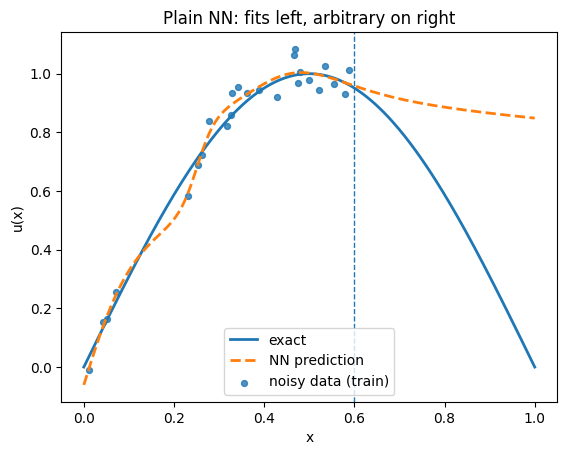

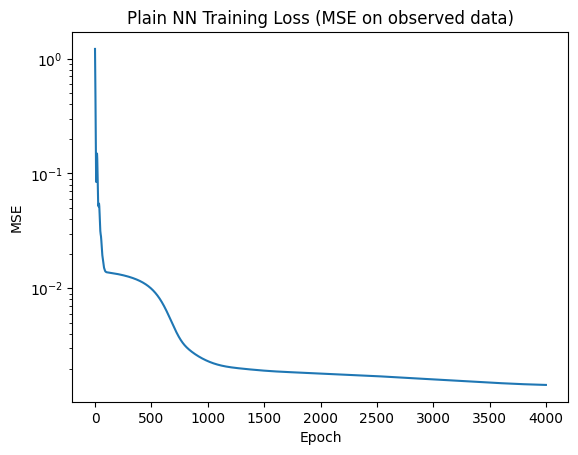

In [8]:

#@title Evaluate plain NN on [0,1] and plot
xg_t = to_torch(x_grid[:,None])
with torch.no_grad():
    y_nn = nn_model(xg_t).cpu().numpy().squeeze()

# Errors overall and on the unobserved region
mask_right = x_grid > 0.6
mse_full_nn = float(np.mean((y_nn - y_true)**2))
mse_right_nn = float(np.mean((y_nn[mask_right] - y_true[mask_right])**2))
print(f"[NN] MSE (0..1): {mse_full_nn:.4e} | MSE (0.6..1): {mse_right_nn:.4e}")

plt.figure()
plt.plot(x_grid, y_true, linewidth=2, label="exact")
plt.plot(x_grid, y_nn, linewidth=2, linestyle="--", label="NN prediction")
plt.scatter(x_obs, y_obs, s=18, alpha=0.8, label="noisy data (train)")
plt.axvline(0.6, linestyle="--", linewidth=1)
plt.title("Plain NN: fits left, arbitrary on right")
plt.xlabel("x"); plt.ylabel("u(x)")
plt.legend()
plt.show()

plt.figure()
plt.plot(nn_losses)
plt.title("Plain NN Training Loss (MSE on observed data)")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.yscale('log')
plt.show()



## Part 2 — PINN: add physics and boundary terms to the loss

A **Physics‑Informed Neural Network (PINN)** augments the loss with the PDE residual and boundary conditions.

- **Physics residual** at interior collocation points $x_c$:
  $$
  r(x_c) \;=\; u_\theta''(x_c) + a\,\pi^2 \sin(\pi x_c),
  \qquad \mathcal{L}_{\text{pde}} = \frac{1}{|C|}\sum_{x_c\in C} r(x_c)^2.
  $$
- **Boundary loss** at $x=0,1$: $u_\theta(0)=0,\,u_\theta(1)=0$.  
- **(Optional) Data loss** on the observed points $x_i$.

Total loss:
$$
\mathcal{L} = \mathcal{L}_{\text{data}} + \mathcal{L}_{\text{pde}} + \mathcal{L}_{\text{bc}}.
$$

**Intuition:** The physics term acts as a **regularizer** that discourages noisy, non‑physical fits and **guides extrapolation** where data are missing.


In [9]:

#@title Define a PINN and the composite loss
class PINN(nn.Module):
    def __init__(self, hidden=64, learn_a=False, a_init=1.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
        )
        # Optional: a as a learnable parameter (for inverse PINN)
        if learn_a:
            self.a = nn.Parameter(torch.tensor([a_init], dtype=torch.float32, device=device))
        else:
            self.register_buffer("a", torch.tensor([a_init], dtype=torch.float32, device=device))

    def forward(self, x):
        return self.net(x)

def pinn_losses(model, x_obs_t, y_obs_t, x_col_t):
    # Data loss (optional if no data points are provided)
    l_data = torch.tensor(0.0, device=device)
    if x_obs_t is not None and x_obs_t.nelement() > 0:
        pred = model(x_obs_t)
        l_data = torch.mean((pred - y_obs_t)**2)

    # PDE residual on collocation points
    x_col_t.requires_grad_(True)
    u = model(x_col_t)
    du_dx = torch.autograd.grad(u, x_col_t, torch.ones_like(u), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x_col_t, torch.ones_like(du_dx), create_graph=True)[0]
    resid = d2u_dx2 + (model.a * (torch.pi**2) * torch.sin(torch.pi * x_col_t))
    l_pde = torch.mean(resid**2)

    # Boundary loss at x=0,1
    x_b = torch.tensor([[0.0],[1.0]], dtype=torch.float32, device=device, requires_grad=True)
    u_b = model(x_b)
    l_bc = torch.mean(u_b**2)

    total = l_data + l_pde + l_bc
    return total, l_data.detach(), l_pde.detach(), l_bc.detach()


In [10]:

#@title Train the PINN (forward mode, a=1 fixed)
x_col = np.linspace(0.0, 1.0, 60)[:,None]  # interior collocation points
x_col_t = to_torch(x_col, requires_grad=True)

pinn = PINN(learn_a=False, a_init=1.0).to(device)
opt = torch.optim.Adam(pinn.parameters(), lr=1e-3)

pinn_hist = {"total":[], "data":[], "pde":[], "bc":[]}
epochs = 4000
for ep in range(1, epochs+1):
    opt.zero_grad()
    total, l_data, l_pde, l_bc = pinn_losses(pinn, x_obs_t, y_obs_t, x_col_t)
    total.backward()
    opt.step()
    pinn_hist["total"].append(total.item())
    pinn_hist["data"].append(l_data.item())
    pinn_hist["pde"].append(l_pde.item())
    pinn_hist["bc"].append(l_bc.item())
    if ep % 500 == 0 or ep == 1:
        print(f"[PINN] epoch {ep:4d}/{epochs}  total:{total.item():.3e}  data:{l_data.item():.3e}  pde:{l_pde.item():.3e}  bc:{l_bc.item():.3e}")


[PINN] epoch    1/4000  total:4.804e+01  data:5.234e-01  pde:4.750e+01  bc:1.954e-02
[PINN] epoch  500/4000  total:2.720e-03  data:2.146e-03  pde:5.637e-04  bc:1.047e-05
[PINN] epoch 1000/4000  total:2.563e-03  data:2.147e-03  pde:4.051e-04  bc:1.026e-05
[PINN] epoch 1500/4000  total:2.421e-03  data:2.147e-03  pde:2.633e-04  bc:1.030e-05
[PINN] epoch 2000/4000  total:2.306e-03  data:2.147e-03  pde:1.483e-04  bc:1.039e-05
[PINN] epoch 2500/4000  total:2.242e-03  data:2.147e-03  pde:8.504e-05  bc:1.050e-05
[PINN] epoch 3000/4000  total:2.220e-03  data:2.147e-03  pde:6.234e-05  bc:1.060e-05
[PINN] epoch 3500/4000  total:2.210e-03  data:2.147e-03  pde:5.281e-05  bc:1.066e-05
[PINN] epoch 4000/4000  total:2.670e-03  data:2.168e-03  pde:4.848e-04  bc:1.766e-05


[PINN] MSE (0..1): 1.8481e-05 | MSE (0.6..1): 5.2042e-06


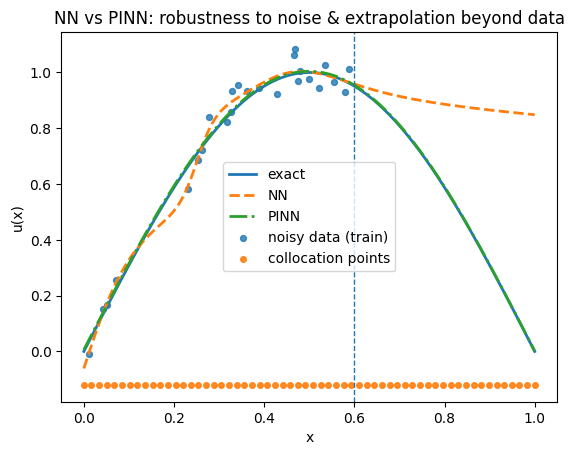

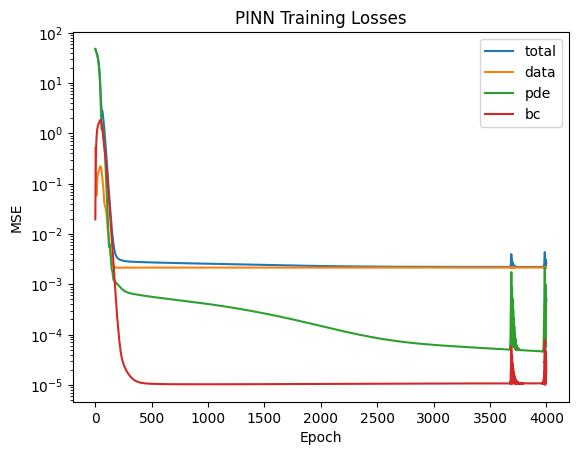

In [11]:

#@title Evaluate PINN on [0,1] and plot
with torch.no_grad():
    y_pinn = pinn(xg_t).cpu().numpy().squeeze()

mask_right = x_grid > 0.6
mse_full_pinn = float(np.mean((y_pinn - y_true)**2))
mse_right_pinn = float(np.mean((y_pinn[mask_right] - y_true[mask_right])**2))
print(f"[PINN] MSE (0..1): {mse_full_pinn:.4e} | MSE (0.6..1): {mse_right_pinn:.4e}")

# Establish a baseline a bit below the visible range for a 'rug' of collocation points
y_min, y_max = float(np.min(y_true)), float(np.max(y_true))
baseline = y_min - 0.12*(y_max - y_min)
y_rug = np.full_like(x_col.flatten(), baseline)


plt.figure()
plt.plot(x_grid, y_true, linewidth=2, label="exact")
plt.plot(x_grid, y_nn, linewidth=2, linestyle="--", label="NN")
plt.plot(x_grid, y_pinn, linewidth=2, linestyle="-.", label="PINN")
plt.scatter(x_obs, y_obs, s=18, alpha=0.8, label="noisy data (train)")
plt.axvline(0.6, linestyle="--", linewidth=1)
plt.title("NN vs PINN: robustness to noise & extrapolation beyond data")
plt.xlabel("x"); plt.ylabel("u(x)")

# Collocation points at the bottom
plt.scatter(x_col.flatten(), y_rug, s=16, alpha=0.9, label="collocation points")

plt.legend()
plt.show()

plt.figure()
plt.plot(pinn_hist["total"], label="total")
plt.plot(pinn_hist["data"], label="data")
plt.plot(pinn_hist["pde"], label="pde")
plt.plot(pinn_hist["bc"], label="bc")
plt.yscale('log')
plt.legend()
plt.title("PINN Training Losses")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.show()



### What we see

- **Noise robustness (regularization):** The PINN respects the PDE and yields a smoother, more physical curve even with noisy data. The physics term acts like a prior that penalizes non‑physical oscillations.
- **Extrapolation:** The NN has no clue beyond $x=0.6$ and can drift; the PINN is **anchored by physics** and continues to follow the correct shape on $[0.6,1]$.
- Numerically, compare the MSE on $[0.6,1]$ printed above—PINN should be significantly lower.



## Part 3 — Inverse PINN: learn the unknown parameter $a$

Now assume $a$ is **unknown**. We make it a learnable parameter and optimize it **together** with the network weights by keeping the *same loss* as before.
This is the hallmark of inverse PINNs: just treat physical parameters as additional trainable variables.

We generate data with $a=1$ (as before) and see if the inverse PINN recovers it.


In [13]:

#@title Train an inverse PINN with learnable 'a'
inv_pinn = PINN(learn_a=True, a_init=0.5).to(device)  # intentionally mis-initialized
opt = torch.optim.Adam(inv_pinn.parameters(), lr=1e-3)

inv_hist = {"a":[], "total":[]}
epochs = 10000
for ep in range(1, epochs+1):
    opt.zero_grad()
    total, l_data, l_pde, l_bc = pinn_losses(inv_pinn, x_obs_t, y_obs_t, x_col_t)
    total.backward()
    opt.step()
    inv_hist["a"].append(inv_pinn.a.item())
    inv_hist["total"].append(total.item())
    if ep % 500 == 0 or ep == 1:
        print(f"[InvPINN] epoch {ep:4d}/{epochs}  total:{total.item():.3e}  a:{inv_pinn.a.item():.4f}")


[InvPINN] epoch    1/10000  total:1.162e+01  a:0.4990
[InvPINN] epoch  500/10000  total:1.169e-01  a:0.4749
[InvPINN] epoch 1000/10000  total:1.014e-01  a:0.5083
[InvPINN] epoch 1500/10000  total:8.390e-02  a:0.5544
[InvPINN] epoch 2000/10000  total:6.475e-02  a:0.6111
[InvPINN] epoch 2500/10000  total:4.609e-02  a:0.6759
[InvPINN] epoch 3000/10000  total:2.982e-02  a:0.7450
[InvPINN] epoch 3500/10000  total:1.734e-02  a:0.8137
[InvPINN] epoch 4000/10000  total:9.146e-03  a:0.8768
[InvPINN] epoch 4500/10000  total:4.721e-03  a:0.9291
[InvPINN] epoch 5000/10000  total:3.072e-03  a:0.9675
[InvPINN] epoch 5500/10000  total:2.347e-03  a:0.9914
[InvPINN] epoch 6000/10000  total:2.139e-03  a:1.0036
[InvPINN] epoch 6500/10000  total:2.122e-03  a:1.0084
[InvPINN] epoch 7000/10000  total:2.124e-03  a:1.0098
[InvPINN] epoch 7500/10000  total:2.121e-03  a:1.0101
[InvPINN] epoch 8000/10000  total:2.120e-03  a:1.0102
[InvPINN] epoch 8500/10000  total:2.124e-03  a:1.0101
[InvPINN] epoch 9000/10000  

True a = 1.0000 | Learned a = 1.0100


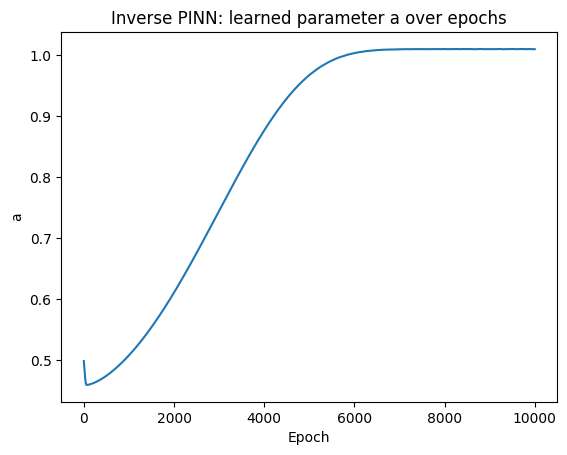

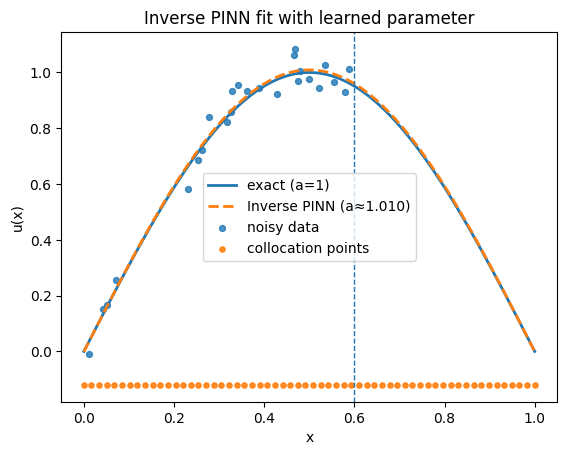

In [14]:

#@title Evaluate inverse PINN and report learned parameter
with torch.no_grad():
    y_inv = inv_pinn(xg_t).cpu().numpy().squeeze()
a_learned = inv_pinn.a.item()
print(f"True a = {a_true:.4f} | Learned a = {a_learned:.4f}")

plt.figure()
plt.plot(inv_hist["a"])
plt.title("Inverse PINN: learned parameter a over epochs")
plt.xlabel("Epoch"); plt.ylabel("a")
plt.show()

plt.figure()
plt.plot(x_grid, y_true, linewidth=2, label="exact (a=1)")
plt.plot(x_grid, y_inv, linewidth=2, linestyle="--", label=f"Inverse PINN (a≈{a_learned:.3f})")
plt.scatter(x_obs, y_obs, s=18, alpha=0.8, label="noisy data")
plt.axvline(0.6, linestyle="--", linewidth=1)

# Collocation points at the bottom
plt.scatter(x_col.flatten(), y_rug, s=14, alpha=0.9, label="collocation points")

plt.legend()
plt.title("Inverse PINN fit with learned parameter")
plt.xlabel("x"); plt.ylabel("u(x)")
plt.show()



## Takeaways

- A **plain NN** fits data but lacks physical guidance—especially visible with **noise** and **extrapolation**.
- A **PINN** augments the loss with PDE residuals and boundary conditions, acting as a **regularizer** and enabling **physics‑guided extrapolation**.
- In **inverse mode**, physical parameters (like $a$) can be learned by **treating them as trainable variables** and optimizing them jointly with the network.

**Next steps:** try different noise levels, fewer/more collocation points, or switch to a different PDE (e.g., Burgers').
